##**Installing and importing neccesary packages**

In [ ]:
%pip install basemap
%pip install geocoder

import pandas as pd
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
from operator import itemgetter
from tqdm import tqdm
import geocoder
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

     |████████████████████████████████| 862 kB 5.5 MB/s 
     |████████████████████████████████| 6.3 MB 37.3 MB/s 
     |████████████████████████████████| 30.5 MB 51.9 MB/s 
     |████████████████████████████████| 219 kB 45.4 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=db99dc9e42b018af4126e0db58b8c6c1ecfc6df15793c305ad2a9f8ab17a4311
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


     |████████████████████████████████| 98 kB 3.9 MB/s 


##**Reading in the dataset with pandas and making a graph out of it using networkx**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SNA/train/All_Indian_Trains.csv')

In [ ]:
df.head()

Unnamed: 0  Train no.                     Train name  \
0           0      12723         Andhra Pradesh Express   
1           1      22416         Andhra Pradesh Express   
2           2      12724         Andhra Pradesh Express   
3           3      12707  Andhra Pradesh Sampark Kranti   
4           4      15909            Abadh Assam Express   

                  Starts                Ends  
0        Hyderabad Decan           New Delhi  
1              New Delhi       Vishakapatnam  
2              New Delhi     Hyderabad Decan  
3               Tirupati        H Nizamuddin  
4  New Tinsukia Junction  Darbhanga Junction

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4024 non-null   int64 
 1   Train no.   4024 non-null   int64 
 2   Train name  4024 non-null   object
 3   Starts      4024 non-null   object
 4   Ends        4024 non-null   object
dtypes: int64(2), object(3)
memory usage: 157.3+ KB


In [ ]:
cols = ['Starts','Ends']
trains = df[cols]

In [ ]:
trains.head()

Starts                Ends
0        Hyderabad Decan           New Delhi
1              New Delhi       Vishakapatnam
2              New Delhi     Hyderabad Decan
3               Tirupati        H Nizamuddin
4  New Tinsukia Junction  Darbhanga Junction

In [ ]:
trains.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Starts  4024 non-null   object
 1   Ends    4024 non-null   object
dtypes: object(2)
memory usage: 63.0+ KB


In [ ]:
G = nx.DiGraph()

In [ ]:
for i in range(4024):
  G.add_edge(trains['Starts'][i],trains['Ends'][i])

In [ ]:
print(nx.info(G))

DiGraph with 390 nodes and 2662 edges


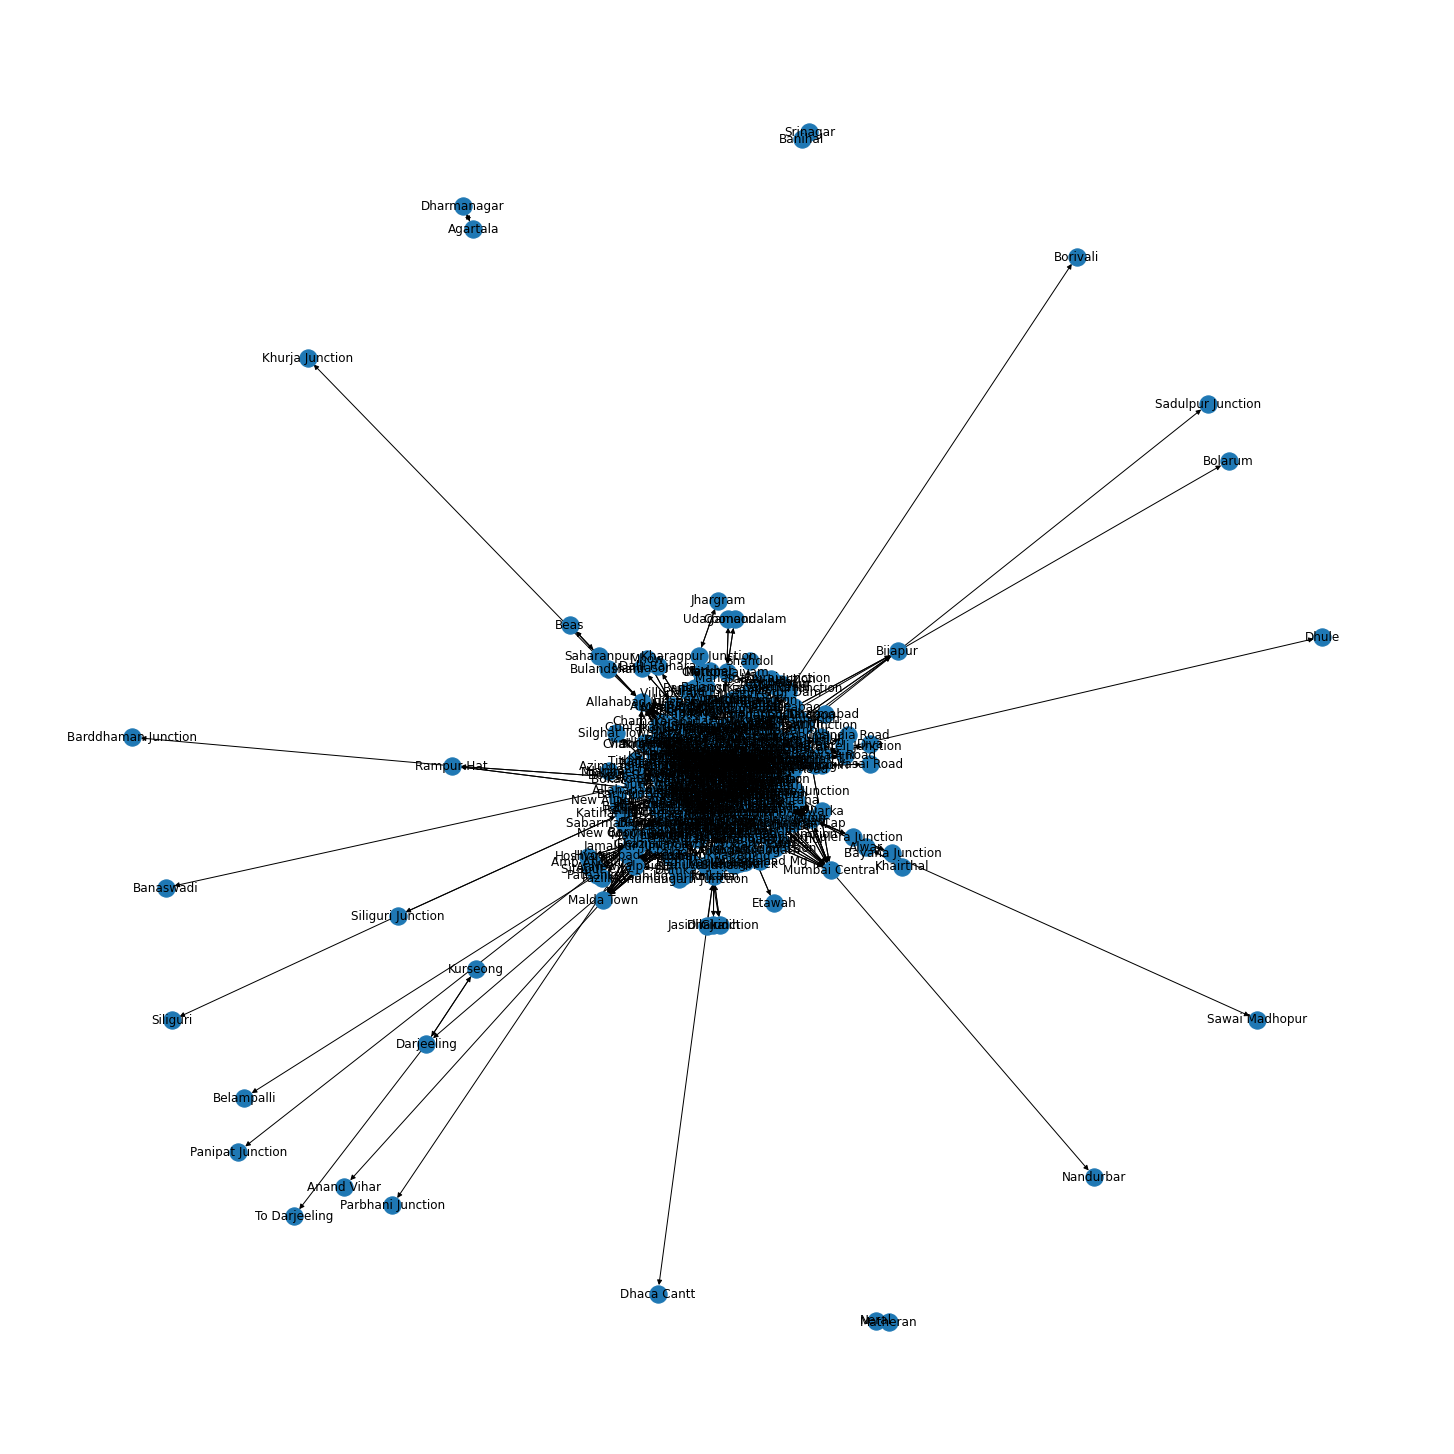

In [ ]:
plt.figure(figsize=(20,20))
pos=nx.spring_layout(G)
nx.draw(G,with_labels=True,pos=pos)

##**Removing Disconnected Components OR Cleaning the Graph**

In [ ]:
print("Weakly Connected Components:",nx.number_weakly_connected_components(G))
print("Strongly Connected Components:",nx.number_strongly_connected_components(G))

Weakly Connected Components: 4
Strongly Connected Components: 39


In [ ]:
for component in list(nx.weakly_connected_components(G)):
    if len(component)<3:
        for node in component:
            G.remove_node(node)

for component in list(nx.strongly_connected_components(G)):
    if len(component)<3:
        for node in component:
            G.remove_node(node)

In [ ]:
print("Weakly Connected Components:",nx.number_weakly_connected_components(G))
print("Strongly Connected Components:",nx.number_strongly_connected_components(G))

Weakly Connected Components: 1
Strongly Connected Components: 1


In [ ]:
print(len(max(nx.weakly_connected_components(G))))
print(len(max(nx.strongly_connected_components(G))))

349
349


In [ ]:
print(nx.info(G))

DiGraph with 349 nodes and 2620 edges


##**Better Visualization of the Graph on the map of India**

In [ ]:
station = []
lats = []
lngs = []

for name in tqdm(G.nodes):
  g = geocoder.arcgis(name + " station, India")
  station.append(name)
  lats.append(g.lat)
  lngs.append(g.lng)

100%|██████████| 349/349 [03:25<00:00,  1.70it/s]


In [ ]:
loc_df = pd.DataFrame(list(zip(station,lats,lngs)),columns=['Station','Latitude','Longitude'])

In [ ]:
loc_df.head()

Station  Latitude  Longitude
0  Hyderabad Decan  17.39183   78.46828
1        New Delhi  28.64465   77.22302
2    Vishakapatnam  17.72158   83.29067
3         Tirupati  19.13552   72.85073
4     H Nizamuddin  28.58887   77.24712

In [ ]:
loc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Station    349 non-null    object 
 1   Latitude   349 non-null    float64
 2   Longitude  349 non-null    float64
dtypes: float64(2), object(1)
memory usage: 8.3+ KB


In [ ]:
def plotOnMap(node_color='r', node_size=200):
  plt.figure(figsize = (20,15))
  m = Basemap(projection='merc',resolution='l',llcrnrlon=67,llcrnrlat=5,urcrnrlon=99,urcrnrlat=37,lat_ts=0)
  mx, my = m(loc_df['Longitude'].values, loc_df['Latitude'].values)
  pos = {}
  for count, elem in enumerate (loc_df['Station']):
    pos[elem] = (mx[count], my[count])

  nx.draw_networkx_nodes(G, pos = pos,node_color=node_color,node_size=node_size)
  nx.draw_networkx_edges(G, pos = pos,edge_color=[0,0,0,0.1])

  m.drawcountries(linewidth = 3)
  m.drawstates(linewidth = 0.2)
  m.drawcoastlines(linewidth=3)
  plt.tight_layout()

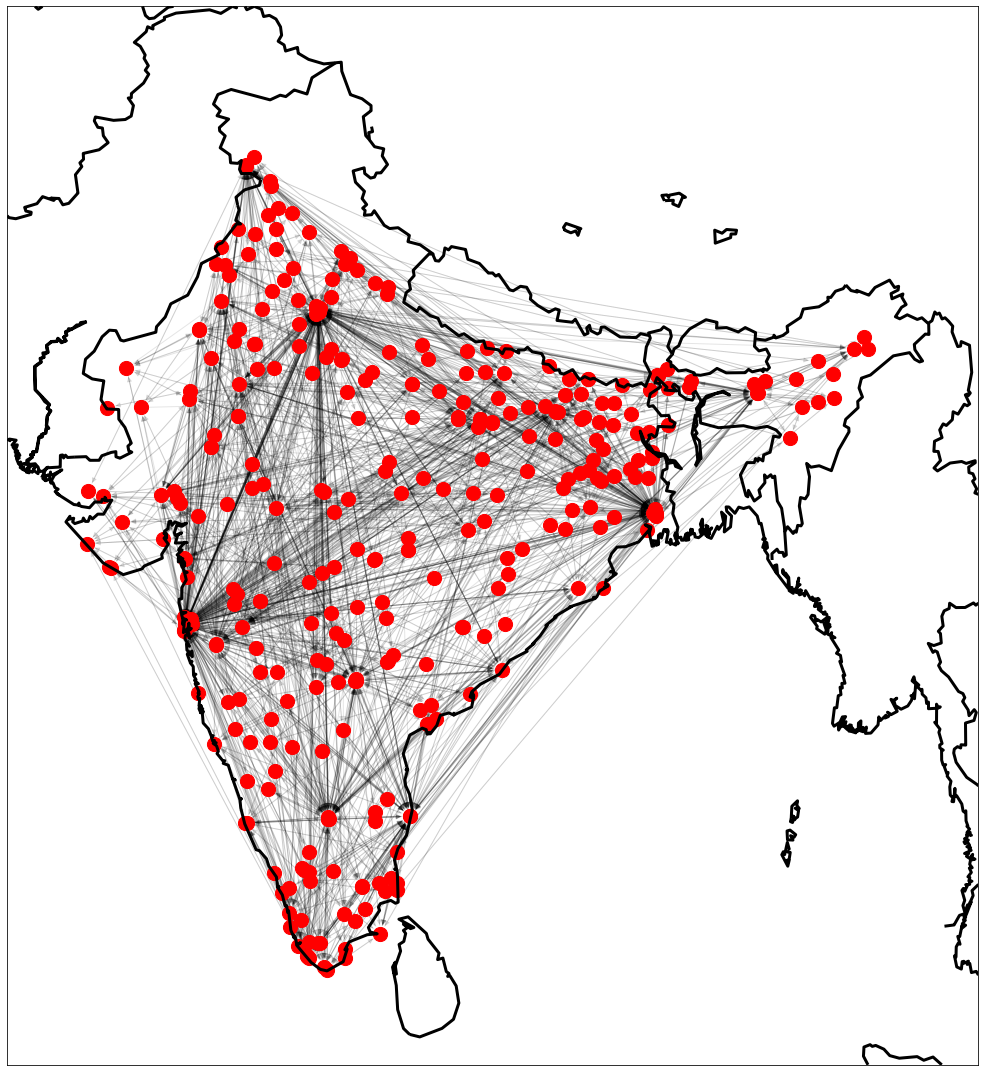

In [ ]:
plotOnMap()

##**Analysis on the basis of various centralities**

In [ ]:
def printTopN(dct,N):
  res = dict(sorted(dct.items(), key = itemgetter(1), reverse = True)[:N])
  for key in res.keys():
    print(key, res[key])

In [ ]:
print("Most of the trains start from the following stations:")
printTopN(dict(G.out_degree),10)

Most of the trains start from the following stations:
Howrah Junction 72
Lokmanyatilak T 58
New Delhi 57
Yesvantpur Junction 50
Chennai Central 48
Patna Junction 41
Ajmer Junction 39
Ahmedabad Junction 38
Pune Junction 37
Secunderabad Junction 37


In [ ]:
print("Most of the trains end on the following stations:")
printTopN(dict(G.in_degree),10)

Most of the trains end on the following stations:
Howrah Junction 70
New Delhi 59
Lokmanyatilak T 58
Chennai Central 52
Yesvantpur Junction 48
Secunderabad Junction 40
Mumbai Cst 40
Ajmer Junction 38
Ahmedabad Junction 37
Pune Junction 37


In [ ]:
print("Most influential cities according to betweenness centrality:")
printTopN(nx.betweenness_centrality(G),10)

Most influential cities according to betweenness centrality:
Howrah Junction 0.14932789676937633
Lokmanyatilak T 0.09710570891297024
New Delhi 0.09494905859032046
Chennai Central 0.0777087234192908
Yesvantpur Junction 0.0669207087234779
Secunderabad Junction 0.05511580608712789
Delhi 0.051055552435616956
Patna Junction 0.051030223245565956
Ajmer Junction 0.0487748806036205
Chennai Egmore 0.04410742143336501


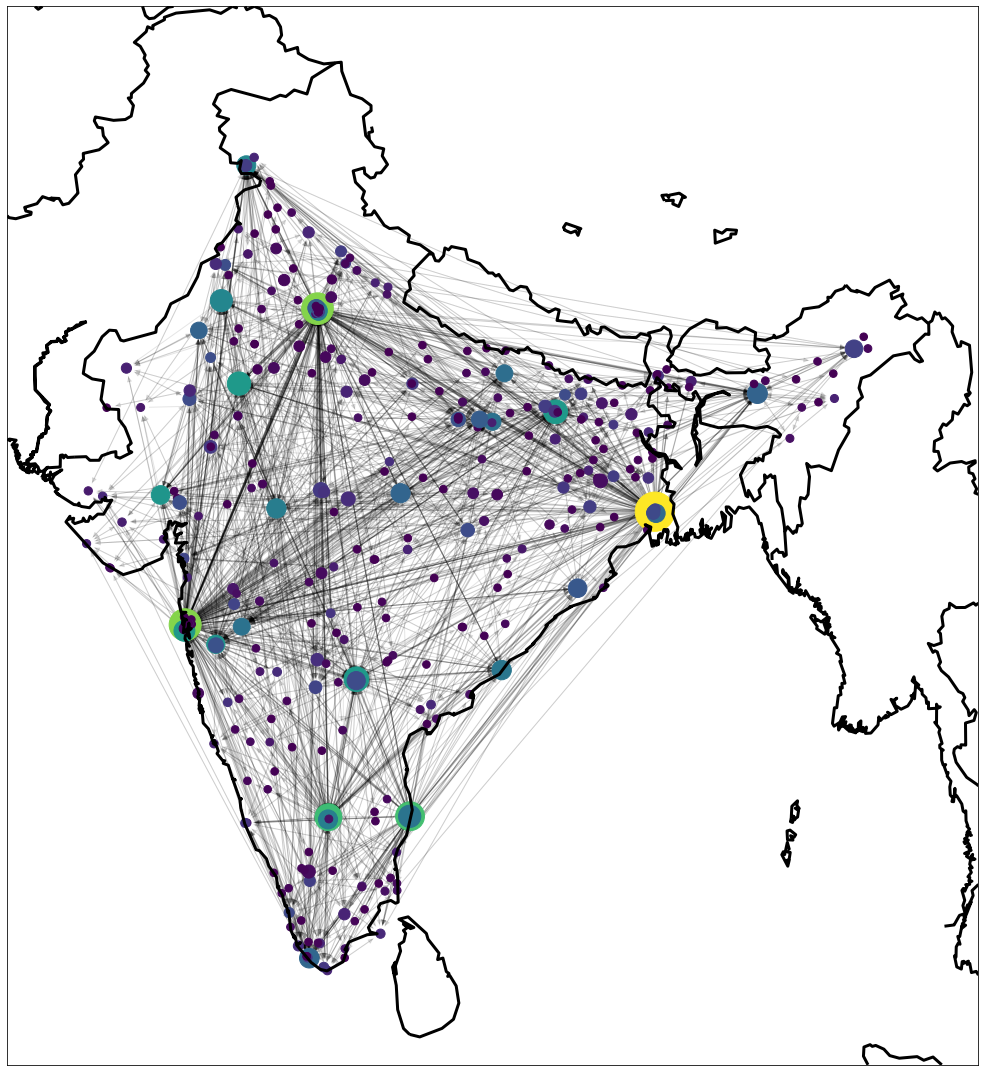

In [ ]:
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size = [v * 10000 for v in betCent.values()]
plotOnMap(node_color=node_color, node_size=node_size)

In [ ]:
eig_cen = nx.eigenvector_centrality(G)
print("Most influential cities according to eigen vector centrality:")
printTopN(eig_cen,10)

Most influential cities according to eigen vector centrality:
Howrah Junction 0.24527293880932532
New Delhi 0.2202230626362209
Chennai Central 0.212237555112324
Lokmanyatilak T 0.1992816217852631
Ahmedabad Junction 0.18108179151045078
Yesvantpur Junction 0.17672900514425904
Ajmer Junction 0.171202505532886
Pune Junction 0.1638834803214224
Jammu Tawi 0.15981791529989423
Mumbai Cst 0.15840696192192677


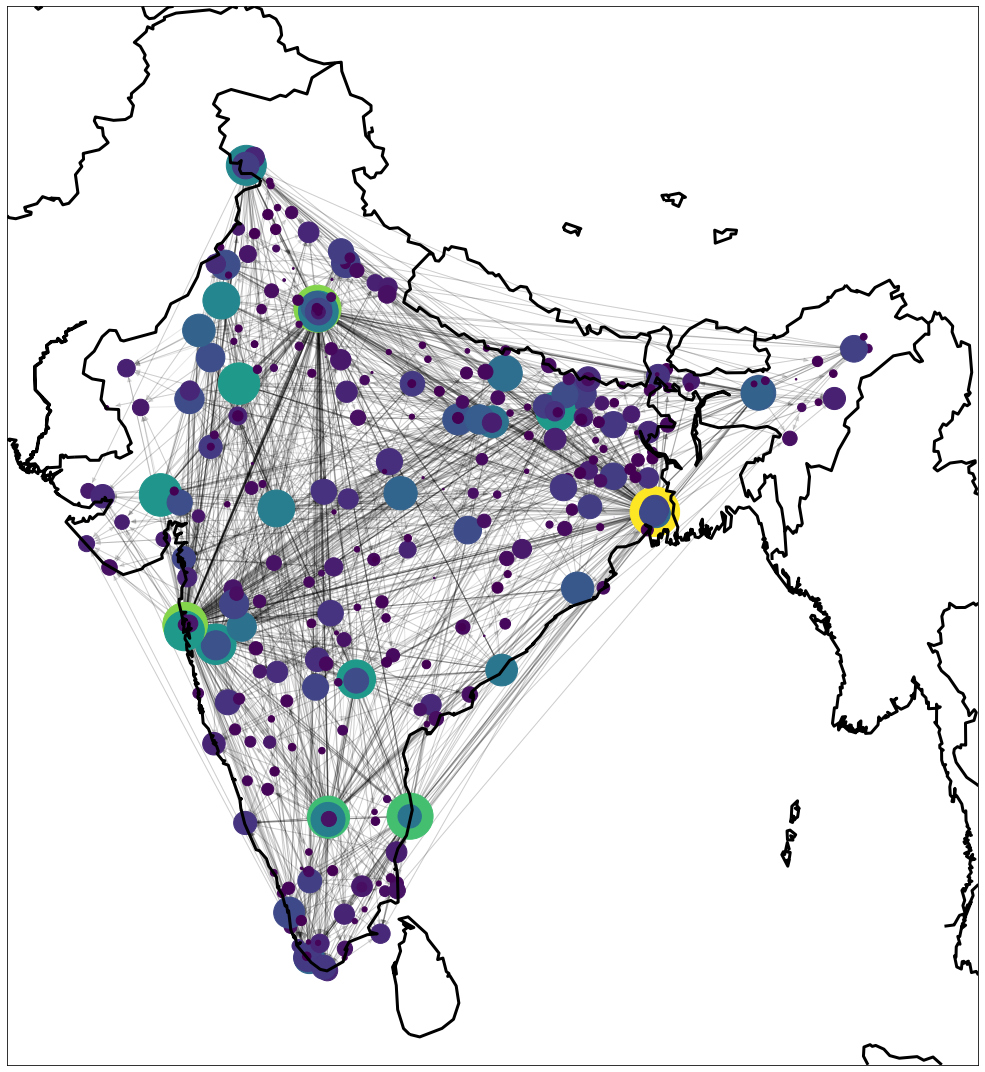

In [ ]:
node_color = [20000.0 * G.degree(v) for v in G]
node_size = [v * 10000 for v in eig_cen.values()]
plotOnMap(node_color=node_color, node_size=node_size)

In [ ]:
clos_cent = nx.closeness_centrality(G)
print("Most influential cities according to closeness centrality:")
printTopN(clos_cent,10)

Most influential cities according to closeness centrality:
Howrah Junction 0.48671328671328673
New Delhi 0.47218453188602444
Chennai Central 0.46837146702557203
Lokmanyatilak T 0.46461949265687585
Yesvantpur Junction 0.4484536082474227
Ajmer Junction 0.4461538461538462
Patna Junction 0.44387755102040816
Mumbai Cst 0.44387755102040816
Ahmedabad Junction 0.44274809160305345
Jammu Tawi 0.44274809160305345


##**Community Detection**

In [ ]:
communities = greedy_modularity_communities(G)

In [ ]:
print("Total {count} number of communities detected in the network".format(count=len(communities)))

Total 11 number of communities detected in the network


In [ ]:
node_groups = []

for i in communities:
  node_groups.append(list(i))

In [ ]:
def set_node_community(G, communities):
        '''Add community to node attributes'''
        for c, v_c in enumerate(communities):
            for v in v_c:
                # Add 1 to save 0 for external edges
                G.nodes[v]['community'] = c + 1

def get_color(i, r_off=1, g_off=1, b_off=1):
        '''Assign a color to a vertex.'''
        r0, g0, b0 = 0, 0, 0
        n = 16
        low, high = 0.1, 0.9
        span = high - low
        r = low + span * (((i + r_off) * 3) % n) / (n - 1)
        g = low + span * (((i + g_off) * 5) % n) / (n - 1)
        b = low + span * (((i + b_off) * 7) % n) / (n - 1)
        return (r, g, b)

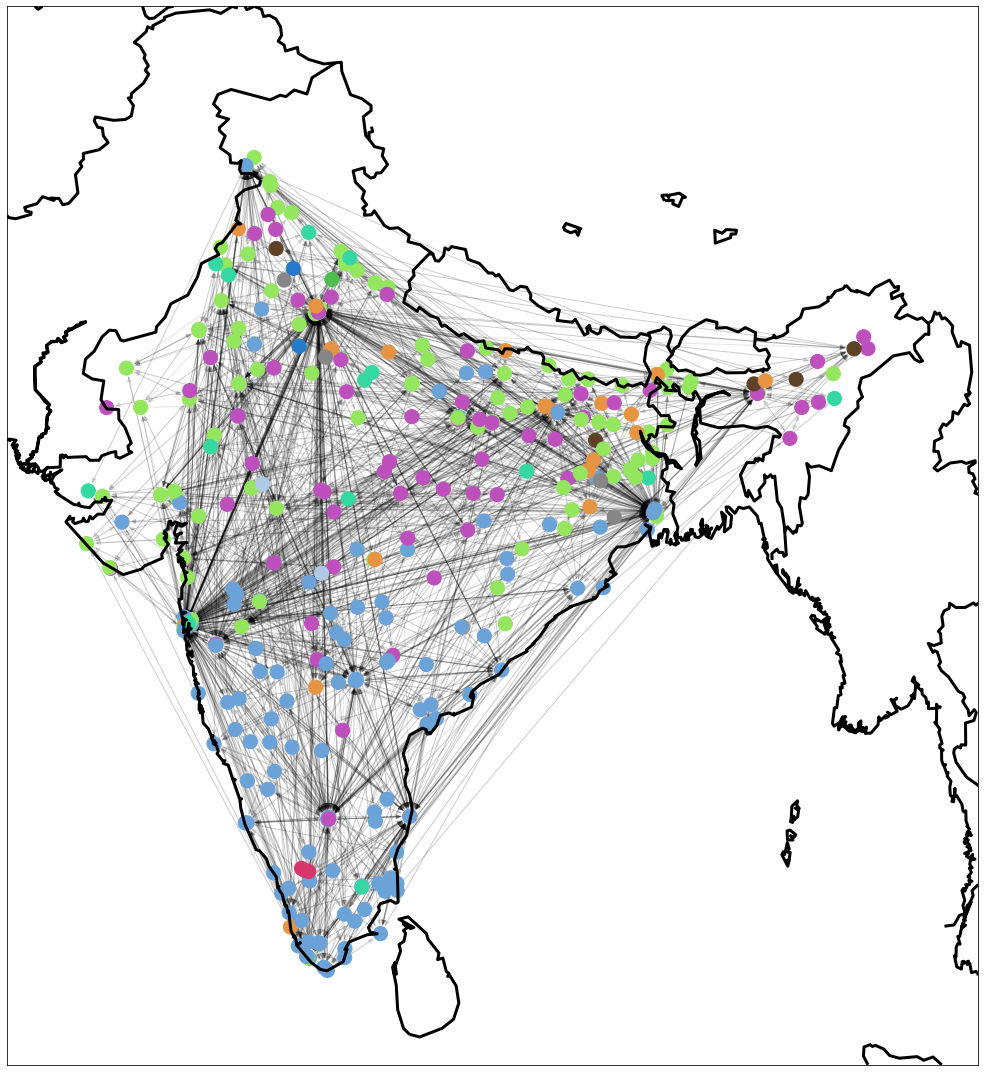

In [ ]:
set_node_community(G, communities)
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
plotOnMap(node_color=node_color)

In [ ]:
communities = greedy_modularity_communities(G,resolution=1.5)

In [ ]:
for community in communities:
  print(len(community))

47
39
39
25
22
22
21
20
20
20
19
16
14
13
9
3


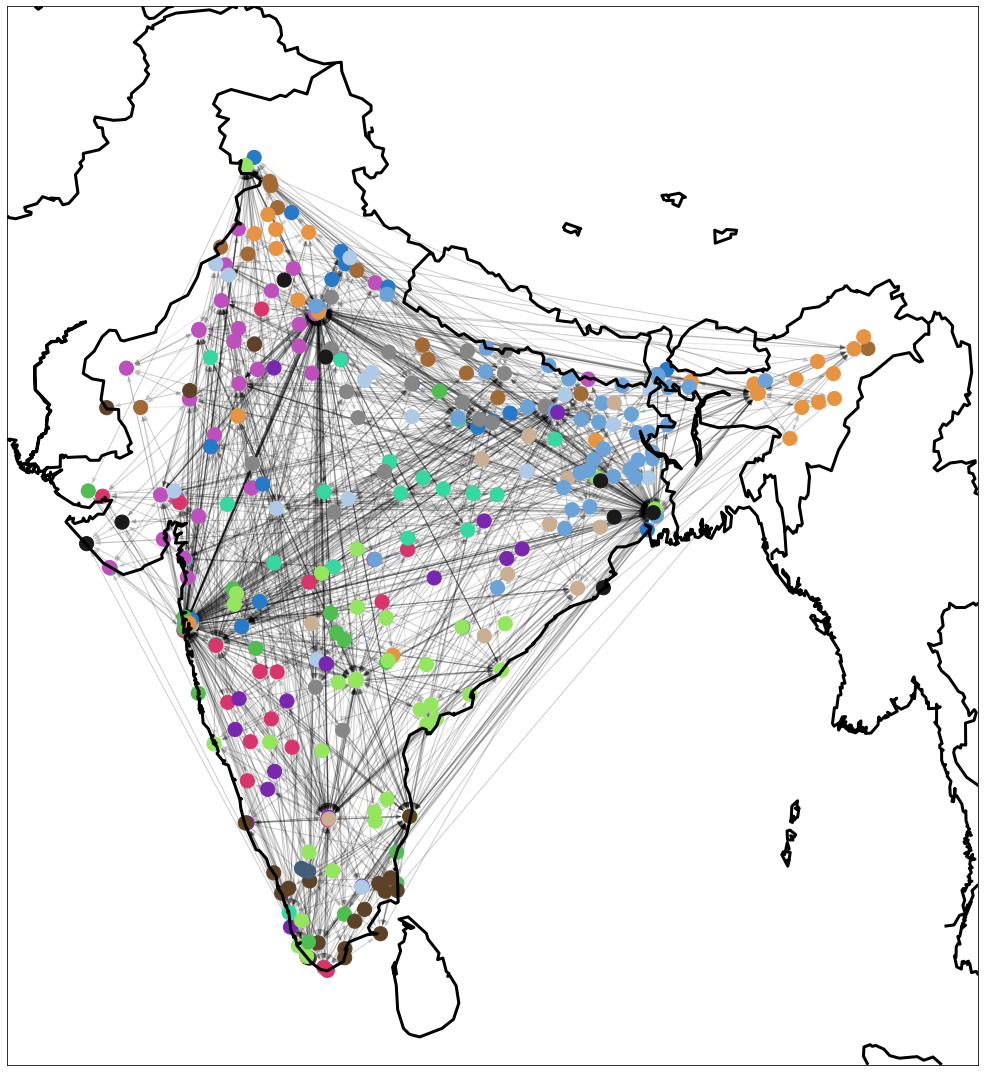

In [ ]:
set_node_community(G, communities)
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
plotOnMap(node_color=node_color)